# Basic Imports

In [1]:
from __future__ import print_function, division
import logging
reload(logging)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s.%(msecs).03d %(name)s %(message)s",
    datefmt='%Y-%m-%dT%H:%M:%S'
)

In [2]:
%matplotlib inline

In [3]:
import pandas
import numpy
from matplotlib import pylab
import seaborn

/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Import Sequencing Data

Selection data needs to be formatted as a "list of dicts" representing each round of selection. This structure is of the form:

````
{ name : # Name of the selection round.
    {
        "parent" : # Name of parent population, if selection was performed, else None
        "selection_level" : # Protease level, if selection was performend, else None
        "fraction_sampled" : # Optional, fraction of population collected during sort, else None
        "selected" : # Integer counts of # of cells selected in round. Derived from sequence data.
    }
}
````

In [307]:
chymo_fit_data = pandas.read_csv("161005_grocklin_chymo_fit_data", delim_whitespace=True)
chymo_src_data = (
    pandas.read_csv("161003_grocklin_chymo_data", delim_whitespace=True)
    .rename(columns={"chymo%s" % i : "rd%s" % i for i in range(1, 7)}))

#seq_counts & num_selected will be used to infer cell counts during selection
chymo_pop_data = {
    "rd0" : dict(seq_counts = chymo_src_data["rd0"], parent = None,  selection_level=None, num_selected=1.5e6, fraction_sampled = None),
    "rd1" : dict(seq_counts = chymo_src_data["rd1"], parent = "rd0", selection_level=1,    num_selected=1.5e6, fraction_sampled = None),
    "rd2" : dict(seq_counts = chymo_src_data["rd2"], parent = "rd0", selection_level=2,    num_selected=540e3, fraction_sampled = None),
    "rd3" : dict(seq_counts = chymo_src_data["rd3"], parent = "rd2", selection_level=3,    num_selected=640e3, fraction_sampled = .46),
    "rd4" : dict(seq_counts = chymo_src_data["rd4"], parent = "rd2", selection_level=4,    num_selected=52e3,  fraction_sampled = .039),
    "rd5" : dict(seq_counts = chymo_src_data["rd5"], parent = "rd4", selection_level=5,    num_selected=114e3, fraction_sampled = .048),
    "rd6" : dict(seq_counts = chymo_src_data["rd6"], parent = "rd4", selection_level=6,    num_selected=63e3,  fraction_sampled = .026),
}

for k, v in chymo_pop_data.items():
    pfrac = v["seq_counts"].values.astype(float) / v['seq_counts'].sum()
    v["selected"] = numpy.floor(pfrac * v["num_selected"])

# Generate Model and fit MAP

In [310]:
import protease_sequencing_model

In [311]:
chymo_model = (
    protease_sequencing_model.FractionalSelectionModel()
    .build_model(chymo_pop_data))

Applied interval-transform to sel_k and added transformed sel_k_interval_ to model.
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


In [312]:
default_map = chymo_model.find_MAP()

In [313]:
chymo_model.logpt(default_map)

array(-437822.1295950188)

In [314]:
default_map

{'sel_ec50': array([ 3.02521813,  1.35703331,  3.01536747, ...,  0.23701118,
         2.5742819 ,  3.38145662]), 'sel_k': array(4.518210885298142)}

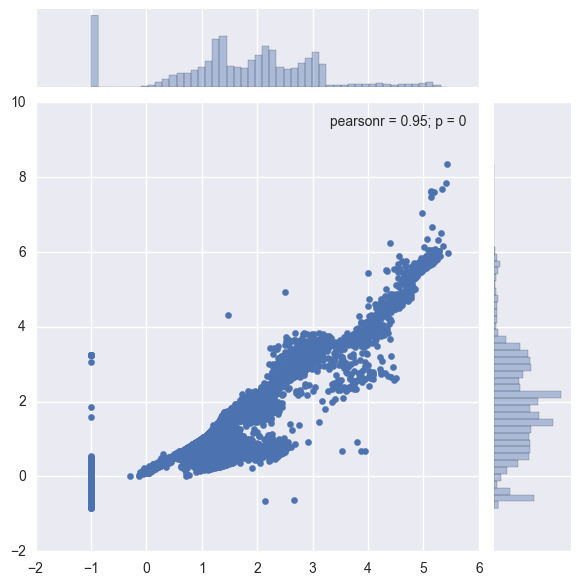

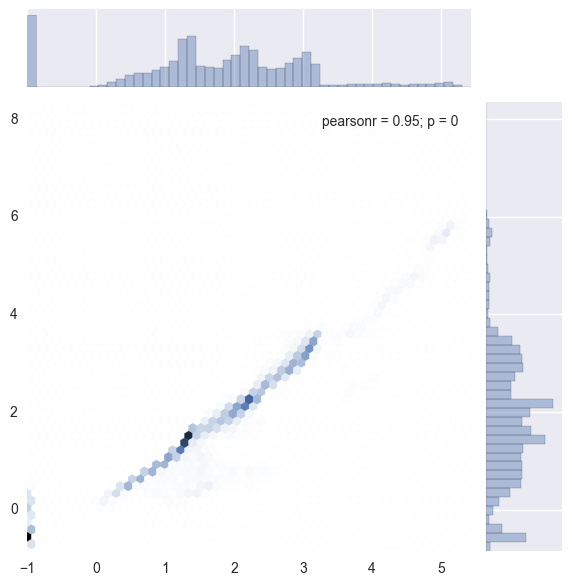

In [320]:
seaborn.jointplot(chymo_fit_data["ec50"].values, default_map["sel_ec50"])
seaborn.jointplot(chymo_fit_data["ec50"].values, default_map["sel_ec50"], kind="hex")

# Fit from alternate start estimates

Model MAP optimization converges on different values depending on initialization values. The majority of this variance is limited to a small number of decoys, the majority converge to nearly identical fit values.

In [315]:
alt_map = chymo_model.find_MAP({"sel_ec50" : default_map["sel_ec50"] + .5 })

In [316]:
chymo_model.logpt(alt_map)

array(-373183.10674311034)

In [317]:
alt_map

{'sel_ec50': array([ 3.03503395,  1.36960034,  3.01219347, ...,  0.39776745,
         2.65291774,  3.35832686]), 'sel_k': array(5.574710468321262)}

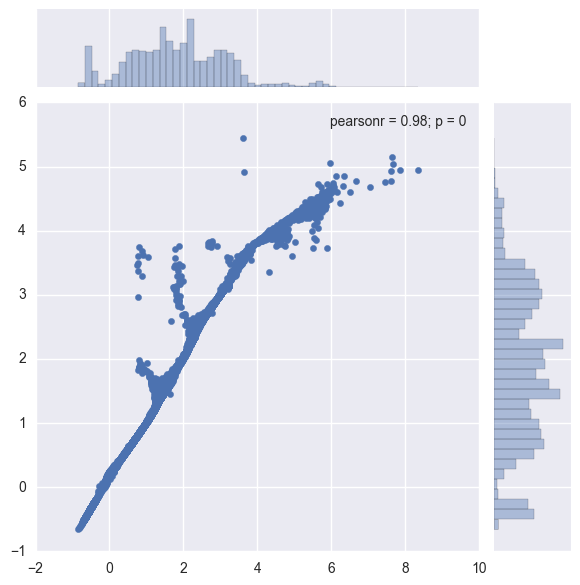

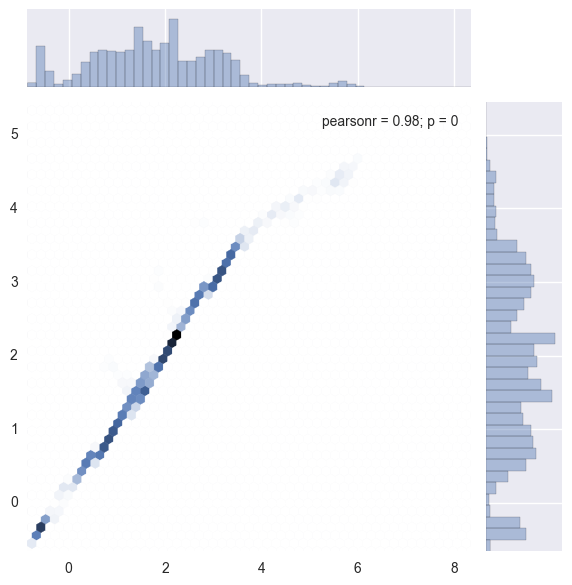

In [318]:
seaborn.jointplot(default_map['sel_ec50'], alt_map["sel_ec50"])
seaborn.jointplot(default_map['sel_ec50'], alt_map["sel_ec50"], kind="hex")